# Score LDL variants for the HepG2 task
Look for variants that increase / decrease expression to explain mechanisms of disease, find causal variants, and predict the most pathogenic variants. Also a validation technique.

1. make bed file with appropriate regions
2. bedtools getfasta for the sequences
3. intialize model
4. convert to one hot
5. try all base pair changes (ISM)
6. compute deepLIFT scores

In [1]:
import os

basePath = '../../data/variants/peyton_gwas/expanded_LD_geno/rsq_0.8/grasp/'
phenotype = 'LDL_cholesterol'
os.system('mkdir ../variant_scoring/%s' % phenotype)
variantBed = open(basePath + phenotype + '_pruned_rsq_0.8_expanded_rsq_0.8.bed')
variantSequenceBed = open('../variant_scoring/%s/variants_sequence_context.bed' % phenotype, 'w')
associatedVariants = []
for line in variantBed:
    line = line.strip().split('\t')
    line[1] = str(int(line[1]) - 72)
    line[2] = str(int(line[2]) + 72)
    associatedVariants.append(line[3])
    variantSequenceBed.write('\t'.join(line) + '\n')
variantBed.close()
variantSequenceBed.close()

In [4]:
!bedtools getfasta -fi /scratch/users/rmovva/data/hg19.fa -bed ../variant_scoring/LDL_cholesterol/variants_sequence_context.bed -fo ../variant_scoring/LDL_cholesterol/variant_sequences.fa

In [2]:
import avutils.util
import deeplift
import deeplift.conversion.keras_conversion as kc
import numpy as np

modelName = "record_13_model_bgGhy_"
modelJson = "../model_files/sharpr_znormed_jul23/" + modelName + "modelJson.json"
modelWeights = "../model_files/sharpr_znormed_jul23/" + modelName + "modelWeights.h5"

keras_model = kc.load_keras_model(modelWeights, json=modelJson)

seqNames = []
seqStrings = []
with open('../variant_scoring/%s/variant_sequences.fa' % phenotype) as seqFile:
    i = 0
    for line in seqFile:
        line = line.strip()
        if i % 2 == 0:
            seqNames.append(line.split('>')[1] + ',' + associatedVariants[i/2])
        else:
            seqStrings.append(line)
        i += 1

import time
t0 = time.time()
seqs = np.array([avutils.util.seq_to_one_hot(seq) for seq in seqStrings]).astype(np.float32)
print("Converting seq strings to one-hot arrays took %.3f sec" % (time.time() - t0))
print seqs.shape

/home/users/rmovva/anaconda2/envs/mommadragonn/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6020 on context None
Mapped name None to device cuda: Tesla P100-PCIE-16GB (0000:82:00.0)
Using Theano backend.


Converting seq strings to one-hot arrays took 46.111 sec
(1003711, 145, 4)


In [3]:
seqs = seqs.astype(np.float32)
seqsMutated = np.ndarray(shape=(4, seqs.shape[0], seqs.shape[1], seqs.shape[2]), dtype=np.float32)
for i in range(4):
    seqs[:, seqs.shape[1]/2] = np.zeros(4)
    seqs[:, seqs.shape[1]/2, i] = 1.0
    seqsMutated[i] = seqs

In [4]:
print seqs[0][72]
print seqsMutated[:, 0, 72, :]

[ 0.  0.  0.  1.]
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


In [5]:
t0 = time.time()
refPreds = keras_model.predict(seqs, batch_size=200)
print("Computing reference predictions took %.3f sec" % (time.time() - t0))

Computing reference predictions took 89.457 sec


In [6]:
mutPreds = np.ndarray(shape=(4, seqs.shape[0], refPreds.shape[1]), dtype=np.float32)
t0 = time.time()
for i in range(len(mutPreds)):
    mutPreds[i] = keras_model.predict(seqsMutated[i], batch_size=200)
print("Computing mutated predictions took %.3f sec" % (time.time() - t0))

Computing mutated predictions took 139.007 sec


In [27]:
np.save("../variant_scoring/LDL_cholesterol/refPreds.npy",
        refPreds)
np.save("../variant_scoring/LDL_cholesterol/mutPreds.npy",
        mutPreds)

In [20]:
# hepg2_scores = np.max(np.abs(np.log2(mutPreds[:, :, 8]) - np.log2(refPreds[:, 8])), axis=0)
# k562_scores = np.max(np.abs(np.log2(mutPreds[:, :, 2]) - np.log2(refPreds[:, 2])), axis=0)
# hepg2_scores = np.log2(np.max(np.abs((mutPreds[:, :, 8] - refPreds[:, 8]) / refPreds[:, 8]), axis=0))
# k562_scores = np.log2(np.max(np.abs((mutPreds[:, :, 2] - refPreds[:, 2]) / refPreds[:, 2]), axis=0))
hepg2_scores = np.max(np.abs(mutPreds[:, :, 8] - refPreds[:, 8]), axis=0)
k562_scores = np.max(np.abs(mutPreds[:, :, 2] - refPreds[:, 2]), axis=0)
# hepg2_scores = np.max(np.abs(mutPreds[:, :, 11] - refPreds[:, 11]), axis=0)
# k562_scores = np.max(np.abs(mutPreds[:, :, 5] - refPreds[:, 5]), axis=0)

In [21]:
hepg2ScoresByTagSnp = {snp: [] for snp in set(associatedVariants)}
k562ScoresByTagSnp = {snp: [] for snp in set(associatedVariants)}
for (i, score) in enumerate(hepg2_scores):
    hepg2ScoresByTagSnp[associatedVariants[i]].append(hepg2_scores[i])
    k562ScoresByTagSnp[associatedVariants[i]].append(k562_scores[i])
hepg2MaxScoresByTagSnp = {snp: np.max(hepg2ScoresByTagSnp[snp]) for snp in hepg2ScoresByTagSnp}
k562MaxScoresByTagSnp = {snp: np.max(k562ScoresByTagSnp[snp]) for snp in k562ScoresByTagSnp}
hepg2SecondScoresByTagSnp = {snp: hepg2ScoresByTagSnp[snp][0] if len(hepg2ScoresByTagSnp[snp]) == 1 else np.sort(hepg2ScoresByTagSnp[snp])[::-1][1] for snp in hepg2ScoresByTagSnp}
k562SecondScoresByTagSnp = {snp: k562ScoresByTagSnp[snp][0] if len(k562ScoresByTagSnp[snp]) == 1 else np.sort(k562ScoresByTagSnp[snp])[::-1][1] for snp in k562ScoresByTagSnp}

In [22]:
print np.mean(hepg2_scores), np.std(hepg2_scores)
print np.mean(k562_scores), np.std(k562_scores)
print np.mean(hepg2MaxScoresByTagSnp.values()), np.std(hepg2MaxScoresByTagSnp.values())
print np.mean(k562MaxScoresByTagSnp.values()), np.std(k562MaxScoresByTagSnp.values())
hepg2Ratios = np.array(hepg2MaxScoresByTagSnp.values()) / np.array(hepg2SecondScoresByTagSnp.values())
k562Ratios = np.array(k562MaxScoresByTagSnp.values()) / np.array(k562SecondScoresByTagSnp.values())
print np.mean(hepg2Ratios), np.std(hepg2Ratios)
print np.mean(k562Ratios), np.std(k562Ratios)

0.04938 0.0425464
0.0619959 0.0434637
0.103606 0.0946029
0.116271 0.0908191
1.53261 1.30825
1.42252 0.942196


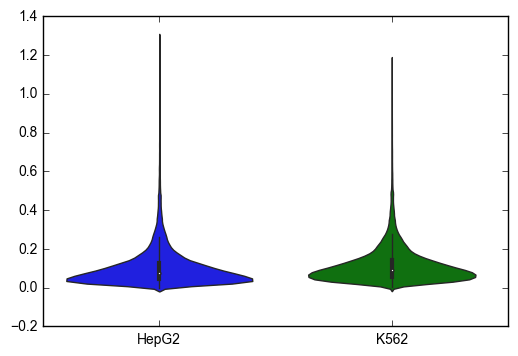

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_dict = {'HepG2': hepg2MaxScoresByTagSnp.values(), 'K562': k562MaxScoresByTagSnp.values()}
df = pd.DataFrame.from_dict(df_dict)

# sns.boxplot(data=df, showfliers=True)
sns.violinplot(data=df, showfliers=True)

plt.show()

In [131]:
print "HepG2"
print np.sort(hepg2_scores)[::-1][:10]
print np.argsort(hepg2_scores)[::-1][:10]
print np.sort(hepg2_scores)[:10]
print np.argsort(hepg2_scores)[:10]
print "K562"
print np.sort(k562_scores)[::-1][:10]
print np.argsort(k562_scores)[::-1][:10]
print np.sort(k562_scores)[:10]
print np.argsort(k562_scores)[:10]
print len(set(np.argsort(k562_scores)[::-1][:10]).intersection(np.argsort(hepg2_scores)[::-1][:10]))

HepG2
[ 1.29019952  1.20572996  1.06968939  1.04579473  1.03509963  0.97602427
  0.96438742  0.95192677  0.94532216  0.93639517]
[808722 231500 210803 621244 648508 414723 494358 631461 497844 566686]
[ 0.00023094  0.00027475  0.00048102  0.000528    0.000606    0.000606
  0.0006067   0.00060672  0.00063346  0.00067669]
[198935  87611 725309 516173 590269 590268  58069  92427 975889 730089]
K562
[ 1.17142379  1.15530252  1.01787317  0.9672491   0.95594156  0.94325411
  0.93980086  0.90893173  0.90420294  0.89360923]
[808722 231500 648508 621244 210803 497844 414723 528849 566686 494358]
[ 0.00036955  0.00052136  0.0005483   0.0006566   0.00089183  0.00104889
  0.00105584  0.00107908  0.00108552  0.00112133]
[ 50779 582144  53781  59562 469238 623531 445132 735473 822081 117239]
9


In [123]:
from scipy.stats import spearmanr

# sample = np.random.choice(np.arange(len(hepg2_scores)), 1000)

print spearmanr(k562_scores, hepg2_scores, nan_policy = 'omit')

SpearmanrResult(correlation=0.7652785229639244, pvalue=0.0)


In [127]:
# Check the top scoring variants to see if they indeed disrupt motif sites.

variant_idxs = np.argsort(hepg2_scores)[::-1][:10]
for (i, variant_idx) in enumerate(variant_idxs):
    print(i+1)
    print hepg2_scores[variant_idx]
    print seqStrings[variant_idx]
    print seqNames[variant_idx]
    print seqStrings[variant_idx][65:80]

1
1.2902
acctggtggaatatgattgaattatggggtcaggtctttcccatgctgttctcatgatagtgaatgggtctcacgagatatgatggttttaaaaatgggagtttctctgcacaagctctctttttttgactgttgccatccatgt
chr6:84544203-84544348,rs16874003
gggtctcacgagata
2
1.20573
gtgtttgcaatgaattttaaaaCGCACATCTGggtcaggtgcggtggctcacacctgtaatcccagcacttcaggaagctgatgtgggaggatcgcttgaggccaggagttcgagacccagcctgggcaacatagtgagatactg
chr12:124410456-124410601,rs11057408
gcacttcaggaagct
3
1.06969
cccaaaagagaaaaaaacagaaaatcgactacagaatgaaaagagaaaggatgctggttcttccactcttccggaagtcactttatgcagaaaggaggagcttgccacaagtaagggaagtgcaacaacagtggccatgtttctt
chr12:55572428-55572573,rs7966464
ctcttccggaagtca
4
1.04579
tggctcttgggggtggattcctcatgaatggctctgtgttgttctctgggccgtgagtgagtttttgctctctcgagactggtttagttcttgggggaatggattagttctcactaataaaagaacaggtttttatagagaaaga
chr3:176929172-176929317,rs9290612
tgctctctcgagact
5
1.0351
ACCGTGATTTAAACATACTTCAAGAggctgggcatggtggctcacgcctgtaatcccagcactttcggaagccgaagtgggtggatcacaaggtcaggagttcaagaccagcctggccaagatggtgaaaccccatctctattaa
chr4:46264609-4626

Motifs for the top 10 matches above ALL correspond to known TFs!
1. ZBTB33
2. ELK1
3. ELK1
4. ZBTB33
5. SPI1_full
6. ELK1
7. NRF1
8. ETV6
9. GABPA
10. ELK1

# Using the Nature Genetics 2013 LDL variant set (un-LD-expanded)

In [81]:
import os

basepath = '../../data/variants/ldl_gwas_reanalysis719/'
path = basepath + 'jointGwasMc_LDL.txt'

Don't need to re-run the below cells:

In [1]:
with open(path) as f:
    with open(basepath + 'ldlGwasWithStatsBed4.bed', 'w') as out:
        header = f.readline()
        header = header.strip().split('\t')[2:]
        newHeader = ['chr', 'start', 'end'] + header
#         out.write('\t'.join(newHeader) + '\n')
        for line in f:
            line = line.strip().split('\t')
            stats = line[2:]
            pos = line[1]
            chrom = pos.split(':')[0]
            start, end = str(int(pos.split(':')[1]) - 72), str(int(pos.split(':')[1]) + 73)
            newLine = [chrom, start, end] + stats
            out.write('\t'.join(newLine[:4]) + '\n')

In [82]:
with open(basepath + 'ldlGwasWithStats_LdExpanded80_v2.bed') as f:
    with open(basepath + 'expanded_tagLd_regions_all.bed', 'w') as out:
        for line in f:
            line = line.strip().split('\t')
            chrom = line[0]
            start, end = str(int(line[1]) - 72), str(int(line[2]) + 72)
            variants = line[3] + ',' + line[4]
            out.write('\t'.join([chrom, start, end, variants]) + '\n')

In [86]:
!bedtools subtract -a ../../data/variants/ldl_gwas_reanalysis719/expanded_tagLd_regions_all.bed -b ../../data/geneCoords/UCSC_exons_hg19_modif_canonical.bed -f 0.2 > ../../data/variants/ldl_gwas_reanalysis719/expanded_tagLd_regions_noExon20pct.bed 

Start from here

In [84]:
from collections import OrderedDict

snpPvals = OrderedDict()
tagSnpCoords = {}

with open(path) as f:
    f.readline() # skip header line
    for line in f:
        line = line.strip().split('\t')
        snpPvals[line[2]] = float(line[-2])
        tagSnpCoords[line[2]] = line[1]

In [85]:
import numpy as np

np.random.seed(72)

useSnp = {snp: False for snp in snpPvals.keys()}

thresh = 5e-3
backgroundFraction = 1.0/200
cnt = 0
for (i, snp) in enumerate(useSnp.keys()):
    pval = snpPvals[snp]
    if pval < thresh:
        useSnp[snp] = True
        cnt += 1
    elif np.random.random() < backgroundFraction:
        useSnp[snp] = True
        cnt += 1
print cnt # Should be around 37.5K at these thresholds

37428


In [97]:
ldBlocks = OrderedDict()
snps = []

bedtoolsFile = open(basepath + 'selected_snp_regions.bed', 'w')

i = 0
with open(basepath + 'expanded_tagLd_regions_all.bed') as f:
    for line in f:
        if i % 10000000 == 0:
            print i
        line = line.strip().split('\t')
        chrom = line[0]
        start = line[1]
        end = line[2]
        if int(end) - int(start) != 145:
            continue
        ldSnp, tagSnp = line[-1].split(',')
        if useSnp[tagSnp] == False:
            i += 1
            continue
        else:
            bedtoolsFile.write('\t'.join([chrom, start, end, ldSnp]) + '\n')
        if tagSnp not in ldBlocks:
            ldBlocks[tagSnp] = []
        ldBlocks[tagSnp].append(ldSnp)
        snps.append((tagSnp, ldSnp))
        i += 1

bedtoolsFile.close()

0
10000000
20000000
30000000
40000000
21148201 21148346
50000000
60000000
70000000
80000000
90000000
160996724 160996869
100000000
110000000


In [98]:
print len(snps) # should be ~2.02 million

2016983


In [99]:
print 10**(-1*np.mean(-1*np.log10(np.array([pval+1e-8 for pval in snpPvals.values()]))))
print np.mean([len(ldBlocks[snp]) for snp in ldBlocks]) 

0.345343877432
55.9247767981


In [101]:
!bedtools getfasta -fi /oak/stanford/groups/akundaje/rmovva/scratch-sep17/data/hg19.fa -bed ../../data/variants/ldl_gwas_reanalysis719/selected_snp_regions.bed -fo ../variant_scoring/LDL_gwasNatGenet_reanalysisJul19/selected_snp_variant_sequences.fa

In [102]:
import avutils.util
import deeplift
import deeplift.conversion.keras_conversion as kc
import numpy as np

modelName = "record_13_model_bgGhy_"
modelJson = "../model_files/sharpr_znormed_jul23/" + modelName + "modelJson.json"
modelWeights = "../model_files/sharpr_znormed_jul23/" + modelName + "modelWeights.h5"

keras_model = kc.load_keras_model(modelWeights, json=modelJson)

seqStrings = []
with open('../variant_scoring/LDL_gwasNatGenet_reanalysisJul19/selected_snp_variant_sequences.fa') as seqFile:
    i = 0
    snpIdx = 0
    for line in seqFile:
        line = line.strip()
        if i % 2 == 1:
            seqStrings.append(line)
            snpIdx += 1
        i += 1

print("nseqs = %d" % len(seqStrings))

nseqs = 2016983


In [103]:
import time
t0 = time.time()
# N = 10000000
seqs = np.array([avutils.util.seq_to_one_hot(seq) for seq in seqStrings]).astype(np.int8)
print("Converting seq strings to one-hot arrays took %.3f sec" % (time.time() - t0))
print seqs.shape

Converting seq strings to one-hot arrays took 95.273 sec
(2016983, 145, 4)


In [104]:
t0 = time.time()
refPreds = keras_model.predict(seqs, batch_size=500)
print("Computing reference predictions took %.3f sec" % (time.time() - t0))

Computing reference predictions took 82.497 sec


In [105]:
# seqs = seqs.astype(np.float16)
seqsMutated = np.ndarray(shape=(4, seqs.shape[0], seqs.shape[1], seqs.shape[2]), dtype=np.int8)
for i in range(4):
    seqs[:, seqs.shape[1]/2] = np.zeros(4)
    seqs[:, seqs.shape[1]/2, i] = 1.0
    seqsMutated[i] = seqs

In [106]:
mutPreds = np.ndarray(shape=(4, seqs.shape[0], refPreds.shape[1]), dtype=np.float32)
t0 = time.time()
for i in range(len(mutPreds)):
    mutPreds[i] = keras_model.predict(seqsMutated[i], batch_size=500)
print("Computing mutated predictions took %.3f sec" % (time.time() - t0))

Computing mutated predictions took 242.053 sec


In [107]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import avutils
from avutils import file_processing as fp
import numpy as np
from collections import OrderedDict
from deeplift.blobs import NonlinearMxtsMode, DenseMxtsMode
import deeplift
reload(deeplift)
import deeplift.conversion.keras_conversion as kc
from deeplift.visualization import viz_sequence

# normalize weights
W, b = keras_model.layers[0].get_weights()
mean_W = np.mean(W, axis = -2)
W = W - mean_W[:, :, None, :]
b = b + np.squeeze(np.sum(mean_W,axis=0))
keras_model.layers[0].set_weights([W, b])

deeplift_model = kc.convert_sequential_model(keras_model,
                                             nonlinear_mxts_mode=deeplift.blobs.NonlinearMxtsMode.DeepLIFT_GenomicsDefault)

deeplift_prediction_function = deeplift_model.get_prediction_function(input_layer_idx = 0,
                                                                      output_layer_idx = -1
                                                                     )

deeplift_scoring_func = deeplift_model.get_target_contribs_func(find_scores_layer_idx = 0,
                                                                target_layer_idx = -1
                                                               )

import avutils
from deeplift.dinuc_shuffle import dinuc_shuffle

seed = 0
deeplift_many_refs_func = deeplift.util.get_shuffle_seq_ref_function(
                                score_computation_function=deeplift_scoring_func, #supply any deeplift scoring function
                                shuffle_func=deeplift.dinuc_shuffle.dinuc_shuffle,
                                seed=seed,
                                one_hot_func=lambda x: np.array([avutils.util.seq_to_one_hot(seq) for seq in x]) #theano_seq_to_2d_image, seq_to_one_hot
                            )

task_idxs = [8]

task_to_deeplift_contribs = OrderedDict()
for task_idx in task_idxs:
    task_to_deeplift_contribs[task_idx] = np.array(deeplift_many_refs_func(
                                                      task_idx = task_idx,
                                                      input_data_sequences=seqStrings,
                                                      num_refs_per_seq=5,
                                                      batch_size=500,
                                                      progress_update=1000000))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 1 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 5 the preceding linear layer is 4 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 10 the preceding linear layer is 8 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
1000000 reference seqs generated
2000000 reference seqs generated
3000000 reference seqs generated
4000000 reference seqs generated
5000000 reference seqs generated
6000000 reference seqs generated
7000000 reference seqs generated
8000000 reference seqs generated
9000000 reference seqs generated
10000000 reference seqs generated
One hot 

In [108]:
task_to_deeplift_summedscores = OrderedDict()
for task_idx in task_idxs:
    summed_scores = np.sum(task_to_deeplift_contribs[task_idx], axis=2)
    task_to_deeplift_summedscores[task_idx] = np.expand_dims(summed_scores, axis=2)*seqs

deepliftTracks = task_to_deeplift_summedscores[8]
deepliftAtVariants = np.abs(np.sum(task_to_deeplift_summedscores[8], axis=2)[:, 72])

print(deepliftTracks.shape)
print(deepliftAtVariants.shape)
print(refPreds.shape)
print(mutPreds.shape)

(2016983, 145, 4)
(2016983,)
(2016983, 12)
(4, 2016983, 12)


In [109]:
np.save("../variant_scoring/LDL_gwasNatGenet_reanalysisJul19/deepliftScoreTracks_all_5e3.npy",
        deepliftTracks)
np.save("../variant_scoring/LDL_gwasNatGenet_reanalysisJul19/deepliftVariantScores_all_5e3.npy",
        deepliftAtVariants)
# deepliftTracks = np.load("../variant_scoring/LDL_gwasNatGenet_reanalysisJul19/deepliftScoreTracks_all_5e3.npy")
# deepliftAtVariants = np.load("../variant_scoring/LDL_gwasNatGenet_reanalysisJul19/deepliftVariantScores_all_5e3.npy")

In [110]:
np.save("../variant_scoring/LDL_gwasNatGenet_reanalysisJul19/refPreds_all_5e3_corrected.npy",
        refPreds)
np.save("../variant_scoring/LDL_gwasNatGenet_reanalysisJul19//mutPreds_all_5e3.npy",
        mutPreds)
# refPreds = np.load("../variant_scoring/LDL_gwasNatGenet_reanalysisJul19/refPreds_all_5e3.npy")
# mutPreds = np.load("../variant_scoring/LDL_gwasNatGenet_reanalysisJul19/mutPreds_all_5e3.npy")

In [111]:
delta = mutPreds[:, :, 8] - refPreds[:, 8]
maxIndices = np.argmax(np.abs(delta), axis=0)

signedScores = []
for (i,idx) in enumerate(maxIndices):
    signedScores.append(delta[idx, i])
signedScores = np.array(signedScores)
signedPercents = 100 * signedScores / np.abs(refPreds[:, 8])
scores = np.max(np.abs(mutPreds[:, :, 8] - refPreds[:, 8]), axis=0)

In [112]:
print signedScores.shape
print signedScores[:10]
print signedPercents[:10]

(2016983,)
[ 0.03527339 -0.10402271 -0.00867018  0.02783748  0.21458735  0.23288257
 -0.08354464  0.02100098 -0.0505816  -0.05905305]
[  15.05239677  -50.03264618   -3.20743299   26.39821815   61.10199356
  159.55963135  -59.51534653    7.06885719  -87.63848114  -24.38024521]


In [113]:
print scores.shape
print len(snps)
print snps[0]
# print len(set([snp[0] for snp in snps]))
# print len(set([snp[1] for snp in snps]))

(2016983,)
2016983
('rs11260549', 'rs147241137')


In [158]:
from collections import OrderedDict

scoresPerTagSnp = OrderedDict()
percentsPerTagSnp = OrderedDict()
ldSnpsPerTagSnp = OrderedDict()

for (i, score) in enumerate(signedScores):
    if i >= len(snps):
        break
    tagSnp, ldSnp = snps[i]
    if tagSnp not in scoresPerTagSnp:
        scoresPerTagSnp[tagSnp] = []
    scoresPerTagSnp[tagSnp].append(score)
    if tagSnp not in percentsPerTagSnp:
        percentsPerTagSnp[tagSnp] = []
    percentsPerTagSnp[tagSnp].append(signedPercents[i])
    if tagSnp not in ldSnpsPerTagSnp:
        ldSnpsPerTagSnp[tagSnp] = []
    ldSnpsPerTagSnp[tagSnp].append(ldSnp)

tagSnpScores = OrderedDict()
    
for (i, score) in enumerate(signedScores):
    tagSnp, ldSnp = snps[i]
    if ldSnp in scoresPerTagSnp:
        tagSnpScores[ldSnp] = score

maxScorePerTagSnp = OrderedDict()
maxPercentPerTagSnp = OrderedDict()
topLdSnpPerTagSnp = OrderedDict()
for tagSnp in scoresPerTagSnp:
    maxAbsIdx = np.argmax(np.abs(np.array(scoresPerTagSnp[tagSnp])))
    maxScorePerTagSnp[tagSnp] = scoresPerTagSnp[tagSnp][maxAbsIdx]
    maxPercentAbsIdx = np.argmax(np.abs(np.array(percentsPerTagSnp[tagSnp])))
    maxPercentPerTagSnp[tagSnp] = percentsPerTagSnp[tagSnp][maxAbsIdx]
    topLdSnpPerTagSnp[tagSnp] = ldSnpsPerTagSnp[tagSnp][maxAbsIdx]

In [160]:
print(len(tagSnpScores.keys()))
print(len(scoresPerTagSnp.keys()))

22777
36066


In [115]:
testedTagSnps = []
testedPvals = []
testedMaxScores = []
testedLdBlockSizes = []
testedTopLdSnps = []
testedMaxPercents = []

for snp in maxScorePerTagSnp:
    testedTopLdSnps.append(topLdSnpPerTagSnp[snp])
    testedTagSnps.append(snp)
    testedPvals.append(snpPvals[snp])
    testedMaxScores.append(maxScorePerTagSnp[snp])
    testedLdBlockSizes.append(len(scoresPerTagSnp[snp]))
    testedMaxPercents.append(maxPercentPerTagSnp[snp])
    
testedTagSnps = np.array(testedTagSnps)
testedPvals = np.array(testedPvals)
testedMaxScores = np.array(testedMaxScores)
testedLdBlockSizes = np.array(testedLdBlockSizes)
testedTopLdSnps = np.array(testedTopLdSnps)
testedMaxPercents = np.array(testedMaxPercents)

In [171]:
import scipy.stats as sp

thresh = 5e-8
sig = testedPvals < thresh
sig = np.logical_and(testedPvals < thresh, testedLdBlockSizes < 100)
notsig = testedPvals > 0.1
notsig = np.logical_and(testedPvals > 0.1, testedLdBlockSizes < 100)

sigTagSnpScores = []
for snp in testedTagSnps[sig]:
    if snp in tagSnpScores:
        sigTagSnpScores.append(tagSnpScores[snp])
insigTagSnpScores = []
for snp in testedTagSnps[notsig]:
    if snp in tagSnpScores:
        insigTagSnpScores.append(tagSnpScores[snp])
sigTagSnpScores = np.array(sigTagSnpScores)
insigTagSnpScores = np.array(insigTagSnpScores)
# notsig = np.logical_not(sig)
# notsig = testedPvals > thresh
# notsig = testedPvals > 0.1
# sig = testedPvals < 5e-6
# notsig = testedPvals >= 0.1
print np.sum(sig)
print np.sum(notsig)
print len(sigTagSnpScores)
print len(insigTagSnpScores)

print np.mean([len(scoresPerTagSnp[snp]) for snp in testedTagSnps[sig]]) # average size of sig LD blocks
print np.mean([len(scoresPerTagSnp[snp]) for snp in testedTagSnps[notsig]]) # average size of insig LD blocks

print np.mean(np.abs(testedMaxScores[sig])) # avg LD-adj ISM score of sig SNPs
print np.mean(np.abs(testedMaxScores[notsig])) # avg LD-adj ISM score of insig SNPs
print np.mean(np.abs(sigTagSnpScores)) # avg sig tag SNP ISM score
print np.mean(np.abs(insigTagSnpScores)) # avg insig tag SNP ISM score
# topPercentSigTagSnpScores = sigTagSnpScores[np.abs(sigTagSnpScores) > np.percentile(np.abs(sigTagSnpScores), 
#                                                                                     96.61)]
# print np.mean(np.abs(topPercentSigTagSnpScores)) # avg of top 3% of sig tag SNP ISM score
# print np.median(np.abs(testedMaxScores[sig]))
# print np.median(np.abs(testedMaxScores[notsig]))
# print np.std(np.abs(testedMaxScores[sig]))
# print np.std(np.abs(testedMaxScores[notsig]))

# print np.mean(np.abs(testedMaxPercents[sig]))
# print np.mean(np.abs(testedMaxPercents[notsig]))
# print np.median(np.abs(testedMaxPercents[sig]))
# print np.median(np.abs(testedMaxPercents[notsig]))
# print np.std(np.abs(testedMaxPercents[sig]))
# print np.std(np.abs(testedMaxPercents[notsig]))

print sp.mannwhitneyu(np.abs(testedMaxScores[sig]), np.abs(testedMaxScores[notsig]), alternative = 'greater')
print sp.mannwhitneyu(np.abs(sigTagSnpScores), np.abs(insigTagSnpScores), alternative = 'greater')

2344
9121
2085
1542
29.5482081911
29.3221138033
0.193102
0.167903
0.0502213
0.0491784
MannwhitneyuResult(statistic=11494999.0, pvalue=8.827521439427287e-09)
MannwhitneyuResult(statistic=1599507.0, pvalue=0.60160792768713922)


In [174]:
df_tagScores_dict = {'Significance': [], 'Score': []}
for score in sigTagSnpScores:
    df_tagScores_dict['Significance'].append('sig')
    df_tagScores_dict['Score'].append(np.abs(score))
for score in insigTagSnpScores:
    df_tagScores_dict['Significance'].append('notsig')
    df_tagScores_dict['Score'].append(np.abs(score))
df_tagScores = df.from_dict(df_tagScores_dict)
df_tagScores.to_csv('../variant_scoring/LDL_gwasNatGenet_reanalysisJul19/plotData/tagSnpScores_sigNotSig_5e8_720.csv',
                    sep = ',')

In [148]:
sigClass = []
for i in range(len(sig)):
    if sig[i] == True:
        sigClass.append(1)
    elif notsig[i] == True:
        sigClass.append(0)
    else:
        sigClass.append(-1)
sigClass = np.array(sigClass)

In [151]:
from scipy.stats import spearmanr, pearsonr

inclSnps = sigClass > -1

print spearmanr(np.abs(testedMaxScores[inclSnps]), testedPvals[inclSnps])
print pearsonr(np.abs(testedMaxScores[inclSnps]), testedPvals[inclSnps])
print spearmanr(np.abs(testedMaxPercents[inclSnps]), testedPvals[inclSnps])
print pearsonr(np.abs(testedMaxPercents[inclSnps]), testedPvals[inclSnps])
print spearmanr(np.abs(testedMaxScores), testedPvals)
print pearsonr(np.abs(testedMaxScores), testedPvals)
print spearmanr(np.abs(testedMaxPercents), testedPvals)
print pearsonr(np.abs(testedMaxPercents), testedPvals)

SpearmanrResult(correlation=-0.035110114716800013, pvalue=0.00016980760581690338)
(-0.060283993770407128, 1.0465823805558957e-10)
SpearmanrResult(correlation=-0.047826695692964633, pvalue=3.0006774587667549e-07)
(-0.0090690728611530821, 0.33155688935301664)
SpearmanrResult(correlation=-0.067059696942803879, pvalue=3.1475170159080911e-37)
(-0.058948124297240063, 3.8874850387138528e-29)
SpearmanrResult(correlation=-0.054202841895275813, pvalue=6.9801707573815479e-25)
(-0.001380075225514572, 0.79325835928670396)


In [120]:
print len(set(list(testedTopLdSnps)))

20538


In [141]:
print len(testedMaxScores)

36066


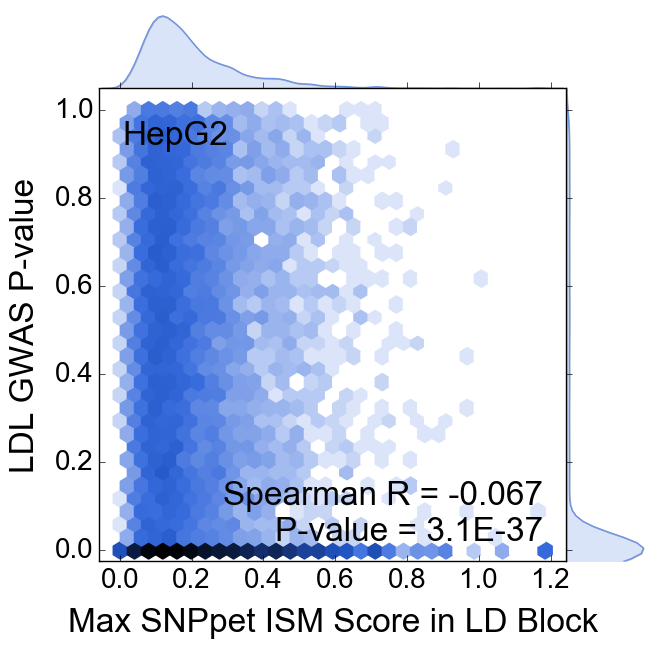

In [121]:
from plot_functions import jointplot

jointplot(vals1 = np.abs(testedMaxScores), 
          vals2 = testedPvals,
          out_pdf = ("../plots/variants/"
                      "variantMaxLdScore_GwasPvalue_correlation_hex_719.png"),
          show = True,
          cor = 'spearmanr',
          square = False,
          despine = False,
          x_label = "Max SNPpet ISM Score in LD Block",
          y_label = "LDL GWAS P-value",
          figsize = 6,
          ratio = 6,
          dpi = 500,
          color = '#6f94e6',
          kde = True,
          bw = 'scott',
          hexbin = True,
          bincount = 30,
          flipAnnotations = True,
          annot = "HepG2",
          axfont = 24,
          tickfont = 20,
         )

In [152]:
negLogP = -1*np.log10(testedPvals + 1e-200)
absScores = np.abs(testedMaxScores)
low = np.logical_and(negLogP < np.percentile(negLogP, 80), absScores < np.percentile(absScores, 80))
high = np.logical_and(negLogP > np.percentile(negLogP, 60), np.logical_or(testedMaxScores > np.percentile(absScores, 90),
                                                                          testedMaxScores < np.percentile(absScores, 10))
                                                                         )
random = np.random.random(len(absScores)) < 0.125
colored = np.logical_and(negLogP > 7.3, np.logical_or(testedMaxScores > 0.45,
                                                      testedMaxScores < -0.45))
show = np.logical_or(np.logical_and(negLogP > 7.3, np.logical_or(testedMaxScores > 0.45, testedMaxScores < -0.45)),
                     np.logical_and(negLogP < 7.3, np.logical_and(testedMaxScores < 0.45, testedMaxScores > -0.45)))
disease = []
for i in range(len(colored)):
    if colored[i] == False:
        disease.append('Not Significant')
    else:
        disease.append('LDL')

In [153]:
print disease.count('Not Significant')
print disease.count('LDL')

35803
263


In [154]:
df_dict = {}

df_dict['tagId'] = testedTagSnps
df_dict['topId'] = testedTopLdSnps
df_dict['pval'] = testedPvals
df_dict['neglogp'] = -1*np.log10(testedPvals + 1e-200)
df_dict['score'] = testedMaxScores
df_dict['absscore'] = np.abs(testedMaxScores)
df_dict['ldblocksize'] = testedLdBlockSizes
df_dict['sig'] = sig
df_dict['notsig'] = notsig
df_dict['sigclass'] = sigClass
df_dict['volcanoend'] = np.logical_or(np.logical_or(low, high), random)
df_dict['percent'] = testedMaxPercents
df_dict['abspercent'] = np.abs(testedMaxPercents)
df_dict['colored'] = colored
df_dict['show'] = show
df_dict['disease'] = disease

import pandas as pd

df = pd.DataFrame.from_dict(df_dict)

df[df['neglogp'] < 49].to_csv('../variant_scoring/LDL_gwasNatGenet_reanalysisJul19/plotData/snpScores_all_5e3_showEdges_LDL_719.csv',
                              sep = ',')
df[df['sigclass'] >= 0].to_csv('../variant_scoring/LDL_gwasNatGenet_reanalysisJul19/plotData/snpScores_all_5e3_sigNotSig_5e8_720.csv',
                               sep = ',')

In [135]:
# df = df.sort_values('score', ascending = False)
idxs = np.logical_and(np.logical_and(testedMaxScores > 0.65, testedMaxScores < 1), testedPvals < 5e-8)
print(set(df['topId'][idxs]))
df[idxs]

set(['rs150309437', 'rs114082649', 'rs174593', 'rs151243996', 'rs12708925', 'rs2254537'])


,abspercent,absscore,colored,disease,ldblocksize,neglogp,notsig,percent,pval,score,show,sig,sigclass,tagId,topId,volcanoend
4661,569.170166,0.736158,True,LDL,30,7.894490,False,569.170166,1.275000e-08,0.736158,True,True,1,rs7096937,rs2254537,True
4666,569.170166,0.736158,True,LDL,31,12.813044,False,569.170166,1.538000e-13,0.736158,True,True,1,rs1129555,rs2254537,True
4668,569.170166,0.736158,True,LDL,54,7.689732,False,569.170166,2.043000e-08,0.736158,True,True,1,rs2803608,rs2254537,True
4670,569.170166,0.736158,True,LDL,45,7.497709,False,569.170166,3.179000e-08,0.736158,True,True,1,rs2297991,rs2254537,True
4682,569.170166,0.736158,True,LDL,26,7.605899,False,569.170166,2.478000e-08,0.736158,True,True,1,rs10787429,rs2254537,True
4684,569.170166,0.736158,True,LDL,27,7.479910,False,569.170166,3.312000e-08,0.736158,True,True,1,rs1807800,rs2254537,True
4685,569.170166,0.736158,True,LDL,26,12.405055,False,569.170166,3.935000e-13,0.736158,True,True,1,rs2250802,rs2254537,True
4687,569.170166,0.736158,True,LDL,26,12.881074,False,569.170166,1.315000e-13,0.736158,True,True,1,rs2255141,rs2254537,True
4688,569.170166,0.736158,True,LDL,26,7.705754,False,569.170166,1.969000e-08,0.736158,True,True,1,rs2255400,rs2254537,True
4689,569.170166,0.736158,True,LDL,26,13.125518,False,569.170166,7.490000e-14,0.736158,True,True,1,rs2419604,rs2254537,True


In [126]:
# df = df.sort_values('score', ascending = True)
idxs = np.logical_and(testedMaxScores < -0.5, testedPvals < 5e-8)
df[idxs]

,abspercent,absscore,colored,disease,ldblocksize,neglogp,notsig,percent,pval,score,show,sig,sigclass,tagId,topId,volcanoend
5656,359.429657,0.566757,True,LDL,214,33.971429,False,-359.429657,1.068000e-34,-0.566757,True,False,-1,rs174538,rs1792895,True
5657,359.429657,0.566757,True,LDL,209,13.518128,False,-359.429657,3.033000e-14,-0.566757,True,False,-1,rs174605,rs1792895,True
14490,327.968628,0.517448,True,LDL,8,46.853252,False,-327.968628,1.402000e-47,-0.517448,True,True,1,rs16979372,rs10422568,True
15041,81.925186,0.756084,True,LDL,51,8.732828,False,-81.925186,1.850000e-09,-0.756084,True,True,1,rs6722374,rs148447107,True
15326,81.925186,0.756084,True,LDL,7,7.889410,False,-81.925186,1.290000e-08,-0.756084,True,True,1,rs72788559,rs148447107,True
19311,142.119400,0.533862,True,LDL,169,16.708187,False,-142.119400,1.958000e-17,-0.533862,True,False,-1,rs2866372,rs760762,True
19368,142.119400,0.533862,True,LDL,72,16.813044,False,-142.119400,1.538000e-17,-0.533862,True,True,1,rs6016534,rs760762,True
19372,142.119400,0.533862,True,LDL,99,16.859492,False,-142.119400,1.382000e-17,-0.533862,True,True,1,rs4812493,rs760762,True
19398,142.119400,0.533862,True,LDL,68,16.637706,False,-142.119400,2.303000e-17,-0.533862,True,True,1,rs3795128,rs760762,True
19432,142.119400,0.533862,True,LDL,73,16.462181,False,-142.119400,3.450000e-17,-0.533862,True,True,1,rs6124323,rs760762,True


In [175]:
# Increase in expression
print snps.index(('rs174591', 'rs174593')) # FADS
print snps.index(('rs6457374', 'rs114082649')) # HLA-C

# Decrease in expression
print snps.index(('rs2235367', 'rs760762')) # LPIN3
print snps.index(('rs16979372', 'rs10422568')) # CEACAM19
print snps.index(('rs6722374', 'rs148447107')) # APOB
print snps.index(('rs6455689', 'rs6923877')) # LPA

325009
1539093
1032883
741234
774653
1766231


-0.139072
[-0.10985392  0.78243583 -0.09853888 -0.13907196]


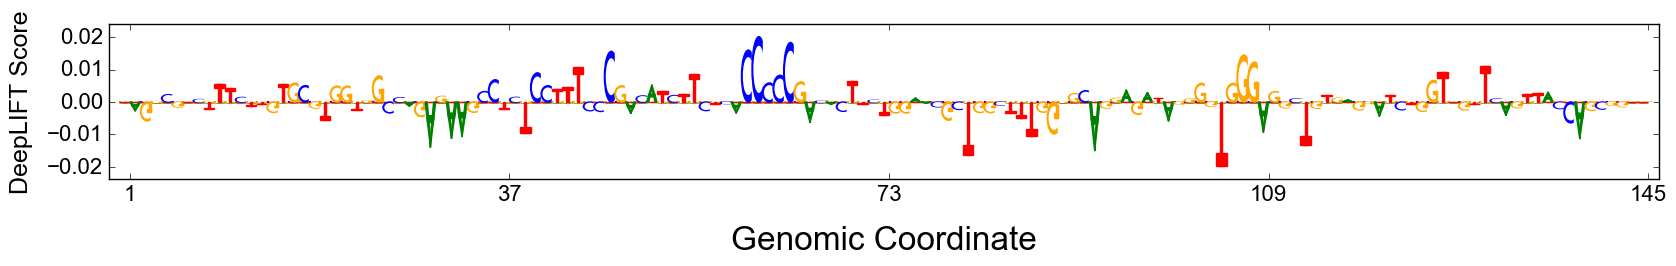

In [178]:
from deeplift.visualization import viz_sequence

# idxs = [779826, 788811, 814606, 733177, 31751, 324202]
idxs = [325009]
origSeq = seqs[idx]

# major allele is T; this is the allele without the motif. 
# for the visualization, using the minor allele (C), to show the motif that is created that confers activity.

for idx in idxs:
    print refPreds[idx, 8]
    print mutPreds[:, idx, 8]
    viz_sequence.plot_weights(task_to_deeplift_summedscores[8][idx],
                              tickcount=4)
    
viz_sequence.plot_weights(task_to_deeplift_summedscores[8][idx][72-25 : 72+25],
                          tickcount=5,
                          save=True,
                          savepath='../plots/variants/rs174593/deepliftTrack_50bp_%d' % idx,
                          dpi=300)

In [179]:
idx = 325009

refPred = refPreds[idx, 8]

origSeq = seqs[idx]
saturationMutSeqs = np.ndarray(shape=(145, 4, 145, 4), dtype=np.int8)
for i in range(145):
    for j in range(4):
        seq = np.copy(origSeq)
        seq[i] = np.zeros(4)
        seq[i, j] = 1
        saturationMutSeqs[i, j] = seq
saturationMutSeqs = np.reshape(saturationMutSeqs, (-1, 145, 4))
saturationMutPreds = keras_model.predict(saturationMutSeqs, batch_size=200)
ismScores = np.transpose(np.reshape(saturationMutPreds[:, 8], (145, 4))) - refPred
print ismScores.shape

(4, 145)


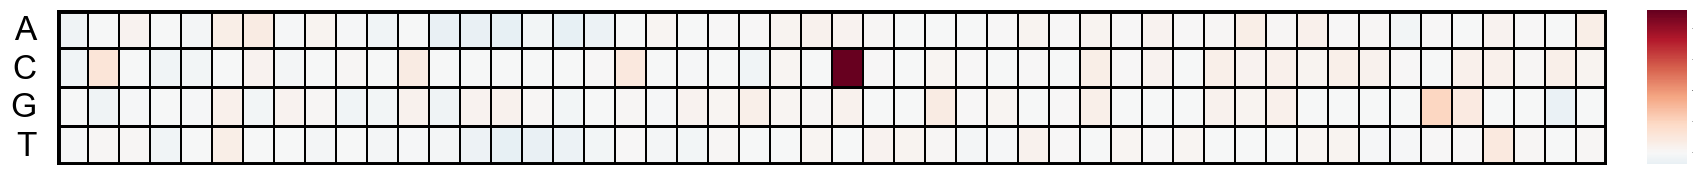

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(20, 2), dpi=300)

ax = fig.add_subplot(1, 1, 1)

cbar_ax = fig.add_axes([.92, 0.128, .02, 0.772])

ax = sns.heatmap(ismScores[:, 72-25 : 72+25], cmap = 'RdBu_r', center = 0,
                 lw = 1.2, linecolor = 'black',
                 ax = ax,
#                  robust = True,
                 cbar_ax = cbar_ax)

ax.add_patch(Rectangle((0, 0), 50, 4, fill=False, edgecolor='black', lw=5))

sns.heatmap(ismScores[:, 72-25 : 72+25], 
            mask = np.abs(ismScores[:, 72-25 : 72+25]) > 0, 
            cbar=False,
            cmap = sns.color_palette("RdGy", n_colors=3),
            lw = 1.2, linecolor = 'black',
            ax = ax)

# bases = ['a', 'c', 'g', 't']
# for (i, base) in enumerate(seqStrings[idx][72-25 : 72+25]):
#     h = bases.index(base)
#     if i == 0:
#         ax.add_patch(Rectangle((i+0.05, h + 0.012), 0.938, 0.976, fill=True, edgecolor='black', lw=0, facecolor='#CCCCCC'))
#     if base == 'a':
#         ax.add_patch(Rectangle((i+0.02, h+0.05), 0.96, 0.8, fill=True, edgecolor='black', lw=0, facecolor='#CCCCCC'))
#     if base == 't':
#         ax.add_patch(Rectangle((i+0.02, h+0.02), 0.96, 0.93, fill=True, edgecolor='black', lw=0, facecolor='#CCCCCC'))
#     ax.add_patch(Rectangle((i+0.012, h+0.012), 0.976, 0.976, fill=True, edgecolor='black', lw=0, facecolor='#CCCCCC'))

ax.set_xticks([])
ax.yaxis.set_ticks_position('none')
locs = [x + 0.55 for x in range(4)]
# ax.set_yticks(locs, ['A', 'C', 'G', 'T'], fontsize = 36, rotation = 0)
# plt.tick_params(axis='y', which='major', labelsize=36)
ax.set_yticks(locs)
ax.set_yticklabels(['A', 'C', 'G', 'T'])
plt.setp(ax.get_yticklabels(), rotation=0, fontsize=24)

cbar_ax.set_frame_on(False)
cbar_ax.yaxis.set_ticks_position('none')
plt.setp(cbar_ax.get_yticklabels(), rotation=0, fontsize=0)
# plt.setp(ax.collections, linewidth = 10)

ax.tick_params(axis='y', which='major', pad=15)

plt.savefig('../plots/variants/rs174593/ismTrack_50bp_%d' % idx, dpi = 600)
plt.show()

In [525]:
print seqStrings[779826]
print seqStrings[779826][62:82]

tttgtatgggtcccatggtgttattcaaggtttatggtattgcagtaaccatgatgaaaaatacatgagaaccggaagagatcacttgttattgcaatatacagtttactggagagataaccttcccatgtggagatgaatagca
acatgagaaccggaagagat


In [481]:
task_to_deeplift_summedscores[8][1956654][:10]

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.        , -0.        , -0.00092608, -0.        ],
       [-0.        , -0.        , -0.00025197, -0.        ],
       [ 0.00165053,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.00025478,  0.        ,  0.        ],
       [-0.        , -0.        , -0.        , -0.00641352],
       [ 0.        ,  0.00460546,  0.        ,  0.        ],
       [-0.        , -0.0021883 , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.0098759 ],
       [-0.        , -0.01111351, -0.        , -0.        ]], dtype=float32)

In [464]:
import inspect
print inspect.getargspec(viz_sequence.plot_weights)

ArgSpec(args=['array', 'figsize', 'height_padding_factor', 'length_padding', 'subticks_frequency', 'colors', 'plot_funcs', 'highlight', 'show', 'save', 'savepath', 'xlabel', 'ylabel', 'tickcount', 'xtickfontsize', 'ytickfontsize', 'start_coord', 'title', 'titlefontsize', 'xaxisfontsize', 'yaxisfontsize', 'xaxispad', 'yaxispad', 'titlepad', 'dpi'], varargs=None, keywords=None, defaults=((20, 2), 0.2, 1.0, 1.0, {0: 'green', 1: 'blue', 2: 'orange', 3: 'red'}, {0: <function plot_a at 0x7fad5eb49e60>, 1: <function plot_c at 0x7fad5eb5f578>, 2: <function plot_g at 0x7fad5eb5f8c0>, 3: <function plot_t at 0x7fad5eb5f938>}, {}, True, False, None, 'Genomic Coordinate', 'DeepLIFT Score', 20.0, 16, 16, None, None, 24, 24, 18, 15, 10, 15, 300))


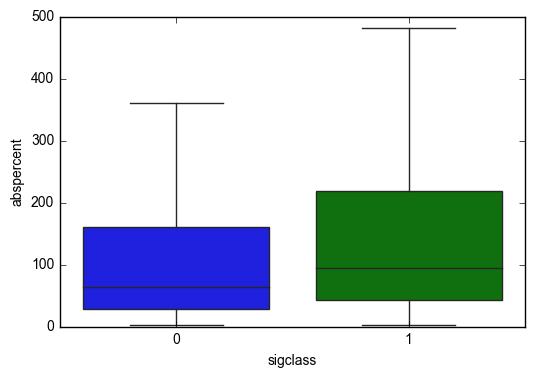

In [409]:
import matplotlib.pyplot as plt
import seaborn as sns

# sns.kdeplot(data = df[df['sigclass'] == 1]['absscore'])
# sns.kdeplot(data = df[df['sigclass'] == 0]['absscore'])
ax = sns.boxplot(data = df[df['sigclass'] >= 0], y = 'abspercent', x = 'sigclass', fliersize=0)

ax.set_ylim(0, 500)

plt.show()

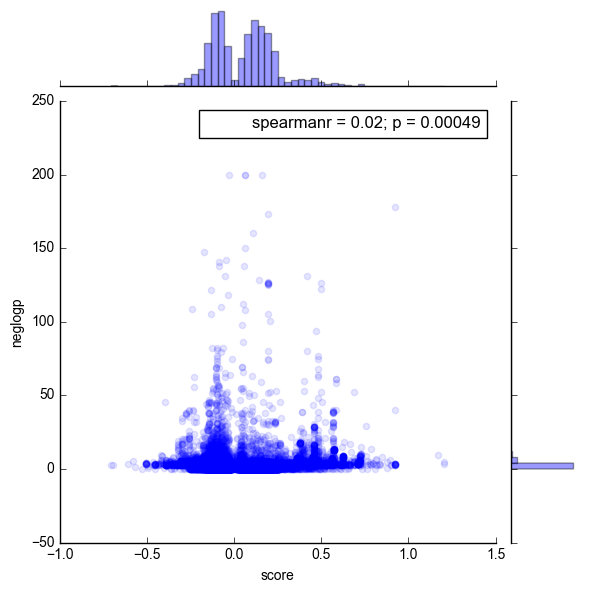

In [380]:
from scipy.stats import spearmanr

sns.jointplot(data = df[df['volcanoend'] == True], x = 'score', y = 'neglogp', stat_func = spearmanr, alpha = 0.1)

plt.show()